In [1]:
# Cell 0: Install dependencies
!pip install pymongo



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Cell 1: Imports and setup
import pandas as pd
import numpy as np
from pymongo import MongoClient
import sys
import os
sys.path.append(os.path.abspath(".."))  # Go up one level to root project folder


from behavioral_alerts.core.utils import *
from behavioral_alerts.core.threshold_adjustment import *
from behavioral_alerts.core.incident_prediction import *
from behavioral_alerts.core.profiling import *
from behavioral_alerts.core.retrain_controller import retrain_user_profile

"""

"""

# Connect to MongoDB and collections
client = MongoClient('mongodb://localhost:27017/')
db = client['hydatis']   # or your DB_NAME
users_collection = setup_users_collection()
ts_collection = setup_timeseries_collection()

# Set user_id for testing
test_user = 'user1'


Collection exists or error: collection user_locations_ts already exists


In [3]:
# Before training/predicting anything
retrain_user_profile(test_user, ts_collection, users_collection)

✅ Retraining behavioral profile for user1
[✓] Saved ML model for user1 in MongoDB
[✓] Saved model locally for user1
[✓] Cached profile in DB for user1 at 2025-07-11 13:18:11 CET
[✓] Saved threshold model for user1 to MongoDB
[✓] Saved threshold model locally for user1
✅ Threshold model updated for user1


In [4]:
# Cell 2: Test Threshold Model

# Prepare data
thresh_features, thresh_target = prepare_threshold_data(ts_collection, test_user)

if thresh_features is None:
    print(f"Insufficient data for threshold model for {test_user}")
else:
    # Train model
    thresh_model = train_threshold_model(thresh_features, thresh_target)
    # Save locally and to DB
    save_threshold_model(
        test_user,
        thresh_model,
        save_to_mongo=True,
        users_collection=users_collection,
        save_local=True
    )
    # Load back from local and from DB
    local_thresh_model = load_threshold_model(test_user)
    db_thresh_doc = users_collection.find_one({"user_id": test_user})
    db_thresh_blob = db_thresh_doc.get('threshold_model', {}).get('model')
    
    # Predict threshold on the same features
    predicted = predict_threshold(thresh_model, thresh_features[0])
    print("Predicted dynamic threshold:", predicted)


[✓] Saved threshold model for user1 to MongoDB
[✓] Saved threshold model locally for user1
Predicted dynamic threshold: 0.049999999999999906


In [5]:
# Cell 3: Test Incident Model

import os
import joblib
import sys
import os
sys.path.append(os.path.abspath(".."))  # Go up one level to root project folder

print("Current working directory:", os.getcwd())

import os
import joblib

def load_incident_model(user_id):
    model_path = os.path.join("..", "behavioral_alerts", "models", user_id, f"{user_id}_xgboost_incident_pred.pkl")
    scaler_path = os.path.join("..", "behavioral_alerts", "models", user_id, f"{user_id}_xgboost_incident_pred_scaler.pkl")
    try:
        model = joblib.load(model_path)
        scaler = joblib.load(scaler_path)
        return model, scaler
    except FileNotFoundError:
        print(f"[✗] Could not find model or scaler at:\n{model_path}\n{scaler_path}")
        return None, None


incident_model, scaler = load_incident_model("user1")
print("Model:", incident_model)
print("Scaler:", scaler)


loaded_db_model, loaded_db_scaler = load_incident_model_from_db(test_user, users_collection)
    # Predict incident probability for a sample anomaly
sample_loc_score = 0.8
sample_time_score = 0.7
prob_local = predict_incident(incident_model, scaler, sample_loc_score, sample_time_score)
prob_db = predict_incident(loaded_db_model, loaded_db_scaler, sample_loc_score, sample_time_score)

if incident_model and scaler:
    prob_local = predict_incident(incident_model, scaler, sample_loc_score, sample_time_score)
    print(f"✅ Incident probability (local model): {prob_local:.2f}")
if loaded_db_model and loaded_db_scaler:
    prob_db = predict_incident(loaded_db_model, loaded_db_scaler, sample_loc_score, sample_time_score)
    print(f"✅ Incident probability (DB model): {prob_db:.2f}")
    


Current working directory: e:\Solution_securite_perso\notebooks
Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)
Scaler: StandardScaler()
✅ Incident probability (local model): 0.10
✅ Incident probability (DB model): 0.10


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:18:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\data\../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)
c:\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.h

In [6]:
# Cell 4: Edge Cases Testing

# Test with insufficient data user
dummy_user = 'new_user'
print("\nTesting with insufficient data for user:", dummy_user)

# Threshold
dummy_thresh, _ = prepare_threshold_data(ts_collection, dummy_user)
print("Threshold preparation result:", dummy_thresh)

# Incident
dummy_inc_feat, _ = prepare_incident_data(users_collection, dummy_user)
print("Incident preparation result:", dummy_inc_feat)



Testing with insufficient data for user: new_user
Threshold preparation result: None
Incident preparation result: None


system gracefully handles edge cases when a user has insufficient or no data.

=> we can use this behavior to skip training/scoring for new users until data is available:
if thresh_features is None:
    print(f"User {user_id} has no enough behavioral history yet. Skipping threshold training.")
else:
    # train/save model



In [7]:

import sys
import os
sys.path.append(os.path.abspath("../behavioral_alerts/core"))
from behavioral_alerts.core.scoring import evaluate_user_behavior

result = evaluate_user_behavior(
    user_id=test_user,
    location_score=0.7,
    time_score=0.6,
    ts_collection=ts_collection,
    incident_model=incident_model,
    scaler=scaler,
    threshold_model=thresh_model
)
if "error" in result:
    print(result["error"])
else:
    print("Probability:", result["incident_probability"])
    print("Threshold:", result["dynamic_threshold"])
    print("Anomaly?", result["anomaly"])



Probability: 0.10366619
Threshold: 0.049999999999999906
Anomaly? True


# TESTING ADDING NEW DATA : DIFF CASE SENARIOS

In [8]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import random

# Generate synthetic user data for 3 different scenarios

def generate_user_data(user_id, start_time, scenario, num_entries=50):
    data = []
    lat, lon = 36.8, 10.18  # base location: Tunis
    
    for i in range(num_entries):
        timestamp = start_time + timedelta(minutes=30 * i)
        if scenario == "predictable":
            # Regular hours (e.g., 9am-11am), little movement
            hour = random.choice([9, 10, 11])
            lat_jitter = random.uniform(-0.001, 0.001)
            lon_jitter = random.uniform(-0.001, 0.001)
        elif scenario == "erratic":
            # All hours, high movement
            hour = random.randint(0, 23)
            lat_jitter = random.uniform(-0.02, 0.02)
            lon_jitter = random.uniform(-0.02, 0.02)
        elif scenario == "new":
            # Few points, random time
            hour = random.randint(0, 23)
            lat_jitter = random.uniform(-0.005, 0.005)
            lon_jitter = random.uniform(-0.005, 0.005)
        else:
            raise ValueError("Unknown scenario")

        point = {
            "user_id": user_id,
            "timestamp": timestamp.replace(hour=hour),
            "latitude": lat + lat_jitter,
            "longitude": lon + lon_jitter
        }
        data.append(point)
    
    return pd.DataFrame(data)

# Generate dataframes
now = datetime.now()
df_predictable = generate_user_data("predictable_user", now - timedelta(days=3), "predictable", 60)
df_erratic = generate_user_data("erratic_user", now - timedelta(days=3), "erratic", 60)
df_new = generate_user_data("new_user", now - timedelta(days=1), "new", 5)

df_predictable.head(), df_erratic.head(), df_new.head()


(            user_id                  timestamp   latitude  longitude
 0  predictable_user 2025-07-08 09:18:14.741828  36.799072  10.179609
 1  predictable_user 2025-07-08 10:48:14.741828  36.800050  10.180011
 2  predictable_user 2025-07-08 09:18:14.741828  36.799153  10.180314
 3  predictable_user 2025-07-08 09:48:14.741828  36.799399  10.180351
 4  predictable_user 2025-07-08 11:18:14.741828  36.800635  10.179515,
         user_id                  timestamp   latitude  longitude
 0  erratic_user 2025-07-08 20:18:14.741828  36.805292  10.185459
 1  erratic_user 2025-07-08 13:48:14.741828  36.802113  10.170609
 2  erratic_user 2025-07-08 00:18:14.741828  36.792839  10.179445
 3  erratic_user 2025-07-08 07:48:14.741828  36.793510  10.162647
 4  erratic_user 2025-07-08 04:18:14.741828  36.817792  10.169133,
     user_id                  timestamp   latitude  longitude
 0  new_user 2025-07-10 10:18:14.741828  36.796584  10.184839
 1  new_user 2025-07-10 22:48:14.741828  36.802558  10.177

In [9]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import random

# Generate synthetic user data for 3 different scenarios

def generate_user_data(user_id, start_time, scenario, num_entries=50):
    data = []
    lat, lon = 36.8, 10.18  # base location: Tunis
    
    for i in range(num_entries):
        timestamp = start_time + timedelta(minutes=30 * i)
        if scenario == "predictable":
            # Regular hours (e.g., 9am-11am), little movement
            hour = random.choice([9, 10, 11])
            lat_jitter = random.uniform(-0.001, 0.001)
            lon_jitter = random.uniform(-0.001, 0.001)
        elif scenario == "erratic":
            # All hours, high movement
            hour = random.randint(0, 23)
            lat_jitter = random.uniform(-0.02, 0.02)
            lon_jitter = random.uniform(-0.02, 0.02)
        elif scenario == "new":
            # Few points, random time
            hour = random.randint(0, 23)
            lat_jitter = random.uniform(-0.005, 0.005)
            lon_jitter = random.uniform(-0.005, 0.005)
        else:
            raise ValueError("Unknown scenario")

        point = {
            "user_id": user_id,
            "timestamp": timestamp.replace(hour=hour),
            "latitude": lat + lat_jitter,
            "longitude": lon + lon_jitter
        }
        data.append(point)
    
    return pd.DataFrame(data)

# Generate dataframes
now = datetime.now()
df_predictable = generate_user_data("predictable_user", now - timedelta(days=3), "predictable", 60)
df_erratic = generate_user_data("erratic_user", now - timedelta(days=3), "erratic", 60)
df_new = generate_user_data("new_user", now - timedelta(days=1), "new", 5)

df_predictable.head(), df_erratic.head(), df_new.head()


(            user_id                  timestamp   latitude  longitude
 0  predictable_user 2025-07-08 09:18:14.794047  36.800086  10.179172
 1  predictable_user 2025-07-08 10:48:14.794047  36.799908  10.180444
 2  predictable_user 2025-07-08 10:18:14.794047  36.800595  10.180576
 3  predictable_user 2025-07-08 11:48:14.794047  36.800178  10.179963
 4  predictable_user 2025-07-08 09:18:14.794047  36.799975  10.180410,
         user_id                  timestamp   latitude  longitude
 0  erratic_user 2025-07-08 01:18:14.794047  36.791686  10.179910
 1  erratic_user 2025-07-08 22:48:14.794047  36.786332  10.172506
 2  erratic_user 2025-07-08 06:18:14.794047  36.816044  10.185079
 3  erratic_user 2025-07-08 07:48:14.794047  36.816906  10.189290
 4  erratic_user 2025-07-08 15:18:14.794047  36.787726  10.168606,
     user_id                  timestamp   latitude  longitude
 0  new_user 2025-07-10 10:18:14.794047  36.802968  10.176303
 1  new_user 2025-07-10 06:48:14.794047  36.800045  10.181

In [23]:
#Inject Synthetic Users into MongoDB
from datetime import datetime, timedelta
import numpy as np
import random

def insert_user_behavior(user_id, pattern="predictable", count=100, ts_collection=None):
    now = datetime.utcnow()
    docs = []
    for i in range(count):
        base_time = now - timedelta(hours=count - i)
        
        if pattern == "predictable":
            hour = random.choice([9, 10, 11])
            lat = 36.8 + np.random.normal(0, 0.0005)
            lon = 10.18 + np.random.normal(0, 0.0005)
        
        elif pattern == "erratic":
            hour = random.randint(0, 23)
            lat = 36.7 + np.random.normal(0, 0.02)
            lon = 10.1 + np.random.normal(0, 0.02)

        elif pattern == "new":
            hour = random.randint(10, 18)
            lat = 36.79 + np.random.normal(0, 0.002)
            lon = 10.17 + np.random.normal(0, 0.002)

        #timestamp = base_time.replace(hour=hour % 24)
        timestamp = timestamp.replace(hour=hour, minute=random.randint(0, 59), second=random.randint(0, 59))

        docs.append({
            "user_id": user_id,
            "timestamp": timestamp,
            "latitude": lat,
            "longitude": lon
        })

    ts_collection.delete_many({"user_id": user_id})  # Clean slate
    ts_collection.insert_many(docs)
    print(f"[✓] Inserted {len(docs)} documents for '{user_id}' ({pattern})")


insert_user_behavior("predictable_user", "predictable", ts_collection=ts_collection)
insert_user_behavior("erratic_user", "erratic", ts_collection=ts_collection)
insert_user_behavior("new_user", "new", count=5, ts_collection=ts_collection)  # only 5 entries



C:\Users\user\AppData\Local\Temp\ipykernel_10224\1438786605.py:7: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow()


UnboundLocalError: cannot access local variable 'timestamp' where it is not associated with a value

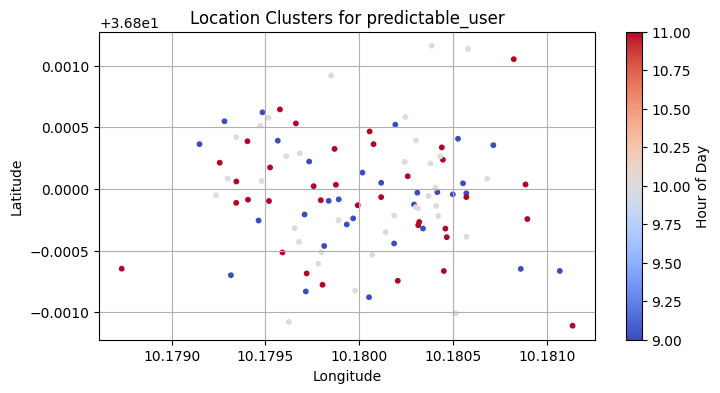

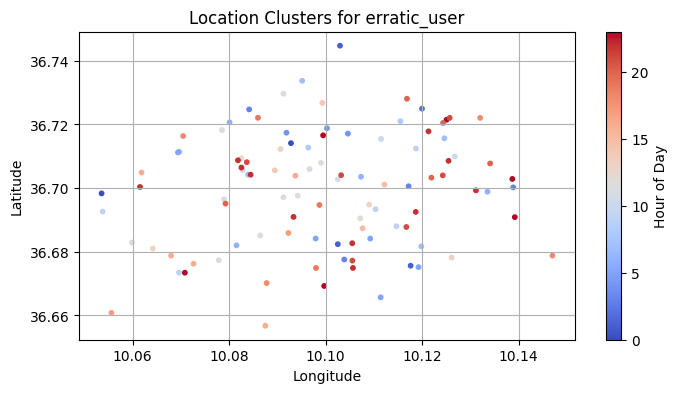

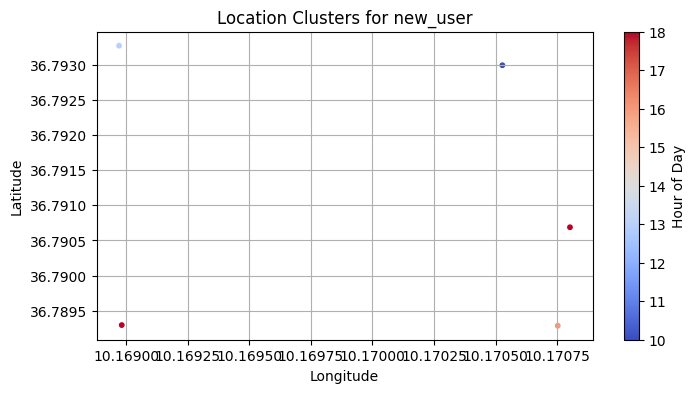

In [24]:
#Visualize User Behavior
import matplotlib.pyplot as plt

def plot_user_behavior(user_id, ts_collection):
    df = pd.DataFrame(list(ts_collection.find({"user_id": user_id})))
    if df.empty:
        print(f"No data for {user_id}")
        return
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["hour"] = df["timestamp"].dt.hour
    
    plt.figure(figsize=(8, 4))
    plt.scatter(df["longitude"], df["latitude"], c=df["hour"], cmap="coolwarm", s=10)
    plt.colorbar(label="Hour of Day")
    plt.title(f"Location Clusters for {user_id}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.show()

plot_user_behavior("predictable_user", ts_collection)
plot_user_behavior("erratic_user", ts_collection)
plot_user_behavior("new_user", ts_collection)



In [25]:
# Cell W: Train and Save Incident Models Per User
from behavioral_alerts.core.incident_prediction import (
    prepare_incident_data,
    train_incident_model,
    save_incident_model
)

for uid in ["predictable_user", "erratic_user", "new_user"]:
    print(f"⏳ Forcing profile retrain for {uid}")
    retrain_user_profile(uid, ts_collection, users_collection)

for uid in ["predictable_user", "erratic_user", "new_user"]:
    profile = users_collection.find_one({"user_id": uid})
    if not profile:
        print(f"[!] No profile found for {uid}")
    else:
        print(f"[✓] Profile for {uid} contains keys: {list(profile.keys())}")


for uid in ["predictable_user", "erratic_user", "new_user"]:
    print(f"\n🧠 Training incident model for {uid}...")

    features, target = prepare_incident_data(users_collection, uid)
    if features is None:
        print(f"[!] Skipping incident model for {uid} — not enough data.")
        continue

    incident_model, scaler = train_incident_model(features, target)

    save_incident_model(uid, incident_model, scaler, users_collection, save_local=True)

    print(f"[✓] Trained and saved incident model for {uid}")


⏳ Forcing profile retrain for predictable_user
✅ Retraining behavioral profile for predictable_user
[✓] Saved threshold model for predictable_user to MongoDB
[✓] Saved threshold model locally for predictable_user
✅ Threshold model updated for predictable_user
⏳ Forcing profile retrain for erratic_user
✅ Retraining behavioral profile for erratic_user
[✓] Saved threshold model for erratic_user to MongoDB
[✓] Saved threshold model locally for erratic_user
✅ Threshold model updated for erratic_user
⏳ Forcing profile retrain for new_user
✅ Retraining behavioral profile for new_user
⚠️ Skipped threshold model retrain — insufficient data for new_user
[✓] Profile for predictable_user contains keys: ['_id', 'user_id', 'ml_model', 'behavior_profile', 'threshold_model']
[✓] Profile for erratic_user contains keys: ['_id', 'user_id', 'ml_model', 'behavior_profile', 'threshold_model']
[!] No profile found for new_user

🧠 Training incident model for predictable_user...
[!] Skipping incident model for

In [26]:
from pprint import pprint

for uid in ["predictable_user", "erratic_user", "new_user"]:
    print(f"\n🔎 Behavior profile for {uid}:")
    user_doc = users_collection.find_one({"user_id": uid})
    if user_doc and "behavior_profile" in user_doc:
        pprint(user_doc["behavior_profile"].keys())
    else:
        print("[!] No profile or missing behavior_profile.")



🔎 Behavior profile for predictable_user:
dict_keys(['centroids', 'hour_freq', 'weekday_freq', 'month_freq', 'last_updated'])

🔎 Behavior profile for erratic_user:
dict_keys(['centroids', 'hour_freq', 'weekday_freq', 'month_freq', 'last_updated'])

🔎 Behavior profile for new_user:
[!] No profile or missing behavior_profile.


In [27]:
# Cell X: Train and Load Models Per User
user_ids = ["predictable_user", "erratic_user", "new_user"]
user_models = {}

for user_id in user_ids:
    print(f"\n🧠 Training models for {user_id}...")

    # Retrain profile
    retrain_user_profile(user_id, ts_collection, users_collection)

    # Threshold model training
    thresh_features, thresh_target = prepare_threshold_data(ts_collection, user_id)
    if thresh_features is not None:
        thresh_model = train_threshold_model(thresh_features, thresh_target)
        save_threshold_model(
            user_id, thresh_model,
            save_to_mongo=True,
            users_collection=users_collection,
            save_local=True
        )
    else:
        thresh_model = None
        print(f"[!] Not enough data for threshold model for {user_id}")

    # Incident model loading (already trained separately)
    incident_model, scaler = load_incident_model(user_id)

    # Store for evaluation
    user_models[user_id] = {
        "incident_model": incident_model,
        "scaler": scaler,
        "threshold_model": thresh_model
    }



🧠 Training models for predictable_user...
✅ Retraining behavioral profile for predictable_user
[✓] Saved threshold model for predictable_user to MongoDB
[✓] Saved threshold model locally for predictable_user
✅ Threshold model updated for predictable_user
[✓] Saved threshold model for predictable_user to MongoDB
[✓] Saved threshold model locally for predictable_user
[✗] Could not find model or scaler at:
..\behavioral_alerts\models\predictable_user\predictable_user_xgboost_incident_pred.pkl
..\behavioral_alerts\models\predictable_user\predictable_user_xgboost_incident_pred_scaler.pkl

🧠 Training models for erratic_user...
✅ Retraining behavioral profile for erratic_user
[✓] Saved threshold model for erratic_user to MongoDB
[✓] Saved threshold model locally for erratic_user
✅ Threshold model updated for erratic_user
[✓] Saved threshold model for erratic_user to MongoDB
[✓] Saved threshold model locally for erratic_user
[✗] Could not find model or scaler at:
..\behavioral_alerts\models\e

In [28]:
# Evaluate Each User with evaluate_user_behavior
from behavioral_alerts.core.scoring import evaluate_user_behavior


for uid in ["predictable_user", "erratic_user", "new_user"]:
    print(f"\n🧪 Results for {uid}:")
    
    incident_model = user_models[uid]["incident_model"]
    scaler = user_models[uid]["scaler"]
    threshold_model = user_models[uid]["threshold_model"]
    
    if not incident_model:
        print(f"[!] No incident model for {uid}")
    if not scaler:
        print(f"[!] No scaler for {uid}")
        
    if not threshold_model:
        print(f"[!] No threshold model for {uid}")
        

    result = evaluate_user_behavior(
        user_id=uid,
        location_score=0.8,
        time_score=0.6,
        ts_collection=ts_collection,
        incident_model=incident_model,
        scaler=scaler,
        threshold_model=threshold_model
    )

    if "error" in result:
        print(result["error"])
    else:
        print("Incident Probability:", result["incident_probability"])
        print("Threshold:", result["dynamic_threshold"])
        print("Anomaly?:", result["anomaly"])



🧪 Results for predictable_user:
[!] No incident model for predictable_user
[!] No scaler for predictable_user


TypeError: cannot unpack non-iterable NoneType object

: 